In [45]:
import transformers
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import os

tf.get_logger().setLevel('ERROR')

# 1. Load BERT Model

Pretrained multi-lingual from HuggingFace

https://huggingface.co/bert-base-uncased

In [2]:
from transformers import BertTokenizer, TFBertModel

# Multi-lingual
mbertTokeniser = BertTokenizer.from_pretrained('bert-base-uncased')
mbertModel = TFBertModel.from_pretrained("bert-base-uncased")

mbertModel.trainable = False

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [3]:
mbertModel.summary()

Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
Total params: 109,482,240
Trainable params: 0
Non-trainable params: 109,482,240
_________________________________________________________________


## Test encoding text in various languages

In [4]:
sentences = [
    'My new book is red',
    'The journal has been approved by the dean!',
    'It was a dangerous explosion caused by chemical reaction',
    'Potassium Nitrate'
]

tensors = [mbertTokeniser(s, return_tensors='tf') for s in sentences]

tensors[0]

{'input_ids': <tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[ 101, 2026, 2047, 2338, 2003, 2417,  102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [5]:
wouts = [mbertModel(t) for t in tensors]

In [6]:
[w for w in wouts[0]] # output structure of BERT

['last_hidden_state', 'pooler_output']

In [7]:
[w[0].numpy().shape for w in wouts] # sequence output

[(1, 7, 768), (1, 11, 768), (1, 11, 768), (1, 4, 768)]

In [8]:
[w[1].numpy().shape for w in wouts] # CLS embedding (pooled) output

[(1, 768), (1, 768), (1, 768), (1, 768)]

In [9]:
# Flatten hidden states of N words in each sentence
# by averaging
fseqs = [w[1].numpy() for w in wouts]
list(map(lambda f: f.shape, fseqs))

[(1, 768), (1, 768), (1, 768), (1, 768)]

In [10]:
encoded = mbertTokeniser.encode('Do you know who i am') # str -> ids
mbertTokeniser.convert_ids_to_tokens(encoded) # ids -> tokens

['[CLS]', 'do', 'you', 'know', 'who', 'i', 'am', '[SEP]']

Distance between each pair of sentences

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
from heapq import heappush, heappop

zs = list(zip(sentences, fseqs))

closest = []
for i,(s1,v1) in enumerate(zs):
    for j,(s2,v2) in enumerate(zs[i+1:]):
        c = cosine_similarity(
            np.atleast_2d(v1.flatten()),
            np.atleast_2d(v2.flatten()))
        heappush(closest, (-c, (s1,s2)))

In [12]:
print('Top 5 closest pairs')
for i in range(5):
    c, (s1,s2) = heappop(closest)
    print('==========================')
    print(f'Rank #{i}, {-c}')
    print(s1)
    print(s2)

Top 5 closest pairs
Rank #0, [[0.97097844]]
It was a dangerous explosion caused by chemical reaction
Potassium Nitrate
Rank #1, [[0.9686246]]
The journal has been approved by the dean!
It was a dangerous explosion caused by chemical reaction
Rank #2, [[0.9531851]]
The journal has been approved by the dean!
Potassium Nitrate
Rank #3, [[0.9341798]]
My new book is red
The journal has been approved by the dean!
Rank #4, [[0.8713379]]
My new book is red
It was a dangerous explosion caused by chemical reaction


These sentence similarities make no sense at all

## Build Classification based on BERT

By freezing pretrained layer of BERT, and add a new softmax layer

In [13]:
mbertModel.trainable = False

In [14]:
mbertModel

Add custom smoothing & classification layers

In [15]:
MAX_LEN = 16

In [16]:
# input layer (1) taking tokenised words
input_ids = keras.layers.Input(
    shape=(MAX_LEN,), 
    dtype=tf.int32,
    name="input_ids")

# input layer (2) taking attention masks (masking paddings)
mask_ids = keras.layers.Input(
    shape=(MAX_LEN,),
    dtype=tf.int32,
    name="attention_mask_ids")

# input layer (3) taking token types
token_type_ids = keras.layers.Input(
    shape=(MAX_LEN,),
    dtype=tf.int32,
    name="token_type_ids")

# BERT layer
outputs = mbertModel(
    input_ids,
    attention_mask=mask_ids,
    token_type_ids=token_type_ids)

# smoothening layers
dense = keras.layers.Dense(768, name="dense")(outputs[1]) # feed BERT's pooled output
dropout = keras.layers.Dropout(0.2, name="dropout")(dense)
norm = keras.layers.LayerNormalization(name="norm")(dropout)
logit = keras.layers.Dense(1, activation='sigmoid', name="logit")(norm)

# Modeling
model = keras.models.Model(
    inputs=[input_ids, mask_ids, token_type_ids],
    outputs=[logit])

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 16)]         0                                            
__________________________________________________________________________________________________
attention_mask_ids (InputLayer) [(None, 16)]         0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 16)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask_ids[0][0]     

In [18]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy'])

## 2. Load tweets data
For classification

In [95]:
# Load pre-cached if exists
path_cache = os.path.join(os.environ['HOME'], 'data', 'tweets', '_cache', 'bert-tokenised.pkl')
if os.path.isfile(path_cache):
    print(f'Loading pre-cached : {path_cache}')
    tweets = pd.read_pickle(path_cache)
else:
    path_tweets = os.path.join(os.environ['HOME'], 'data', 'tweets', 'training.1600000.processed.noemoticon.csv')
    cols = ['sentiment','user','tweet']
    tweets = pd.read_csv(path_tweets, usecols=[0,4,5], header=None, index_col=None)
    tweets.columns = cols
    tweets[:10]

Prepare text input

In [96]:
text = '@' + tweets.loc[:,'user'] + ' ' + tweets.loc[:,'tweet']
text[:10]

0    @_TheSpecialOne_ @switchfoot http://twitpic.co...
1    @scotthamilton is upset that he can't update h...
2    @mattycus @Kenichan I dived many times for the...
3    @ElleCTF my whole body feels itchy and like it...
4    @Karoli @nationwideclass no, it's not behaving...
5              @joy_wolf @Kwesidei not the whole crew 
6                                 @mybirch Need a hug 
7    @coZZ @LOLTrish hey  long time no see! Yes.. R...
8    @2Hood4Hollywood @Tatiana_K nope they didn't h...
9                   @mimismo @twittera que me muera ? 
dtype: object

Define attention mask and token types

In [97]:
if 'token_user' not in tweets.columns:
    tokenise = np.vectorize(mbertTokeniser.encode)
    nrecords = len(tweets)
    print(f'Tokenising users ... {nrecords}')
    tweets.loc[:,'token_user'] = tweets.loc[:,'user'].apply(tokenise)
    print(f'Tokenising tweets ... {nrecords}')
    tweets.loc[:,'token_tweet'] = tweets.loc[:,'tweet'].apply(tokenise)
    print(f'Saving to pre-cached : {path_cache}')
    tweets.to_pickle(path_cache)
else:
    print('Skipping tokenisation, already pre-computed')

Tokenising users ... 1600000
Tokenising tweets ... 1600000
Saving to pre-cached : /Users/pataoengineer/data/tweets/_cache/bert-tokenised.pkl


In [98]:
tweets.iloc[0]['user'] # original user

'_TheSpecialOne_'

In [99]:
mbertTokeniser.convert_ids_to_tokens(tweets.iloc[0]['token_user']) # token user

['[CLS]', '_', 'the', '##sp', '##ec', '##ial', '##one', '_', '[SEP]']

In [100]:
mbertTokeniser.convert_ids_to_tokens(tweets.iloc[0]['token_tweet'])

['[CLS]',
 '@',
 'switch',
 '##foot',
 'http',
 ':',
 '/',
 '/',
 't',
 '##wi',
 '##tp',
 '##ic',
 '.',
 'com',
 '/',
 '2',
 '##y',
 '##1',
 '##z',
 '##l',
 '-',
 'aw',
 '##w',
 '##w',
 ',',
 'that',
 "'",
 's',
 'a',
 'bum',
 '##mer',
 '.',
 'you',
 'should',
 '##a',
 'got',
 'david',
 'carr',
 'of',
 'third',
 'day',
 'to',
 'do',
 'it',
 '.',
 ';',
 'd',
 '[SEP]']

In [101]:
# find max length of vector
def get_len(tw):
    return len(tw)
max(tweets['token_tweet'].apply(get_len))

164

Concatenate user tokens and tweet tokens altogether. 
Also pad the length and record

In [102]:
MAX_LEN = 256
def concat_ids(u, t):
    return np.hstack([u,t[1:]]) # exclude 1st [CLS] from `t`

tweets.loc[:,'ids'] = tweets.apply(
    lambda row: concat_ids(row['token_user'], row['token_tweet']), axis=1)

/Users/pataoengineer/opt/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='len_ids'>

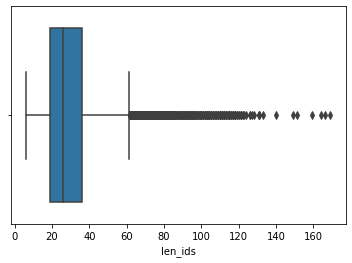

In [103]:
tweets.loc[:,'len_ids'] = tweets['ids'].apply(len)
sns.boxplot(tweets['len_ids'])

In [104]:
# pad ids with zeros so all have same length
tweets.loc[:,'ids'] = tweets.loc[:,'ids'].apply(lambda ids: \
    np.pad(ids, (0, MAX_LEN-len(ids)), constant_values=0))

/Users/pataoengineer/opt/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='ids'>

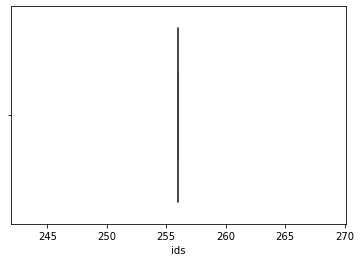

In [105]:
sns.boxplot(tweets['ids'].apply(len)) # lengths after padding

/Users/pataoengineer/opt/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='attention_mask'>

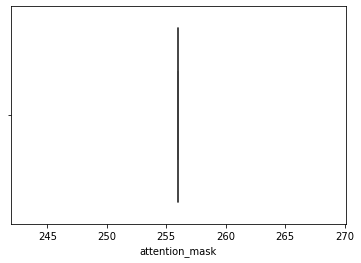

In [106]:
tweets.loc[:,'attention_mask'] = tweets['len_ids'].apply(lambda ld: [1]*ld + [0]*(MAX_LEN-ld))
tweets.loc[:,'token_type'] = tweets['len_ids'].apply(lambda ld: [0]*MAX_LEN)

sns.boxplot(tweets['attention_mask'].apply(len))

In [107]:
tweets.dtypes

sentiment          int64
user              object
tweet             object
token_user        object
token_tweet       object
ids               object
len_ids            int64
attention_mask    object
token_type        object
dtype: object

# 3. Train first model
for classification

In [108]:
from sklearn.model_selection import train_test_split

In [109]:
len(tweets)

1600000

In [110]:
train, test = train_test_split(tweets, test_size=0.3)
len(train), len(test)

(1120000, 480000)

Train BERT-based classification model

In [111]:
model.fit(
    [train['ids'], train['attention_mask'], train['token_type']],
    train['sentiment'],
    epochs=5,
    batch_size=100)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

## Evaluate model (offline)
with test set